In [6]:
import os
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from fuzzywuzzy import process
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from mplsoccer import Sbopen, Pitch, VerticalPitch
pitch = Pitch(goal_type='box')

import warnings
pd.set_option('display.max_columns', None)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings(action="ignore", message="credentials were not supplied. open data access only")
warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')

In [7]:
parser = Sbopen()

competitions = parser.competition()
mls_2023 = competitions[(competitions.competition_name == "Major League Soccer") &
                        (competitions.season_name == "2023")]
mls_2023

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
60,44,107,United States of America,Major League Soccer,male,False,False,2023,2024-05-08T03:02:05.309429,2024-05-08T03:03:06.307921,2024-05-08T03:03:06.307921,2024-05-08T03:02:05.309429


In [8]:
games = pd.concat([parser.match(row.competition_id, row.season_id) for row in mls_2023.itertuples()])
games[["home_team_id", "home_team_name", "away_team_id", "away_team_name", "match_date", "home_score", "away_score"]]

,home_team_id,home_team_name,away_team_id,away_team_name,match_date,home_score,away_score
0,387,New York Red Bulls,1975,Inter Miami,2023-08-27,0,2
1,919,LAFC,1975,Inter Miami,2023-09-04,1,3
2,8070,Charlotte,1975,Inter Miami,2023-10-22,1,0
3,1975,Inter Miami,1938,Nashville SC,2023-08-31,0,0
4,1975,Inter Miami,489,Cincinnati,2023-10-08,0,1
5,1975,Inter Miami,575,Toronto FC,2023-09-21,4,0


In [9]:
match = games[(games.home_team_name == "Inter Miami") & (games.away_team_name == "Toronto FC")]
match_id = match.match_id.values[0]

events_df, related, freeze, tactics = parser.event(match_id)
events_df.head()

,id,index,period,timestamp,minute,second,possession,duration,match_id,type_id,type_name,possession_team_id,possession_team_name,play_pattern_id,play_pattern_name,team_id,team_name,tactics_formation,player_id,player_name,position_id,position_name,pass_recipient_id,pass_recipient_name,pass_length,pass_angle,pass_height_id,pass_height_name,end_x,end_y,body_part_id,body_part_name,sub_type_id,sub_type_name,x,y,under_pressure,outcome_id,outcome_name,counterpress,off_camera,technique_id,technique_name,aerial_won,shot_statsbomb_xg,end_z,shot_first_time,goalkeeper_position_id,goalkeeper_position_name,pass_cross,out,pass_switch,pass_assisted_shot_id,pass_shot_assist,shot_key_pass_id,pass_no_touch,substitution_replacement_id,substitution_replacement_name,dribble_nutmeg,shot_one_on_one,foul_committed_advantage,foul_won_advantage,foul_won_defensive,ball_recovery_recovery_failure,foul_committed_offensive,shot_deflected,block_deflection,dribble_overrun,injury_stoppage_in_chain,pass_goal_assist,pass_deflected
0,a1004642-1b04-42c6-93ce-362b3f9dcc7f,1,1,00:00:00,0,0,1,0.000000,3877115,35,Starting XI,1975,Inter Miami,1,Regular Play,1975,Inter Miami,352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,c792ec58-0657-42f2-8c27-a391def7aef1,2,1,00:00:00,0,0,1,0.000000,3877115,35,Starting XI,1975,Inter Miami,1,Regular Play,575,Toronto FC,433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4ac5b5c0-26c7-4025-ae4c-f250e43deffa,3,1,00:00:00,0,0,1,0.000000,3877115,18,Half Start,1975,Inter Miami,1,Regular Play,575,Toronto FC,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3cd37e19-8b8b-4173-966e-574fda246c84,4,1,00:00:00,0,0,1,0.000000,3877115,18,Half Start,1975,Inter Miami,1,Regular Play,1975,Inter Miami,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,c44d9b22-0fb9-4481-bb1c-f00fb8aab34f,5,1,00:00:01,0,1,2,1.054258,3877115,30,Pass,1975,Inter Miami,9,From Kick Off,1975,Inter Miami,None,12619.0,Josef Alexander Martínez Mencia,24.0,Left Center Forward,5203.0,Sergio Busquets i Burgos,11.034492,-2.38183,1.0,Ground Pass,52.0,32.4,40.0,Right Foot,65.0,Kick Off,60.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# To match the naming of the teams to that done in my other datasets
team_name_mappingSD = {
    "LAFC": "Los Angeles FC",
    "Charlotte": "Charlotte FC",
    "Inter Miami": "Inter Miami CF",
    "Cincinnati": "Cincinnati FC",
}
events_df['team_name'] = events_df['team_name'].replace(team_name_mappingSD)

In [72]:
datafolder = "datasets"
if not os.path.exists(datafolder):
    os.mkdir(datafolder)
    
match_data_file = os.path.join(datafolder, f"match_{match_id}.csv")
events_df.to_csv(match_data_file, index=False)
print(f"Match data stored in {match_data_file}")

Match data stored in datasets\match_3877115.csv


In [6]:
events_df.columns

Index(['id', 'index', 'period', 'timestamp', 'minute', 'second', 'possession',
       'duration', 'match_id', 'type_id', 'type_name', 'possession_team_id',
       'possession_team_name', 'play_pattern_id', 'play_pattern_name',
       'team_id', 'team_name', 'tactics_formation', 'player_id', 'player_name',
       'position_id', 'position_name', 'pass_recipient_id',
       'pass_recipient_name', 'pass_length', 'pass_angle', 'pass_height_id',
       'pass_height_name', 'end_x', 'end_y', 'body_part_id', 'body_part_name',
       'sub_type_id', 'sub_type_name', 'x', 'y', 'under_pressure',
       'outcome_id', 'outcome_name', 'counterpress', 'off_camera',
       'technique_id', 'technique_name', 'aerial_won', 'shot_statsbomb_xg',
       'end_z', 'shot_first_time', 'goalkeeper_position_id',
       'goalkeeper_position_name', 'pass_cross', 'out', 'pass_switch',
       'pass_assisted_shot_id', 'pass_shot_assist', 'shot_key_pass_id',
       'pass_no_touch', 'substitution_replacement_id',
       '

In [7]:
events_df['type_name'].unique()

array(['Starting XI', 'Half Start', 'Pass', 'Ball Receipt', 'Carry',
       'Pressure', 'Foul Committed', 'Foul Won', 'Dispossessed', 'Duel',
       'Ball Recovery', 'Interception', 'Dribble', 'Clearance', 'Block',
       'Dribbled Past', 'Miscontrol', 'Error', 'Shot', 'Goal Keeper',
       'Substitution', '50/50', 'Injury Stoppage', 'Tactical Shift',
       'Referee Ball-Drop', 'Player Off', 'Player On', 'Half End'],
      dtype=object)

### Passes map

In [8]:
def unique_outcome(type_name):
    event = events_df.loc[(events_df['type_name'] == type_name), ['x', 'y', 'end_x', 'end_y', 'outcome_name']]
    failed_event = event[event.outcome_name.notna()]
    return failed_event["outcome_name"].unique()

In [9]:
unique_outcome('Pass')

array(['Incomplete', 'Out', 'Unknown', 'Pass Offside'], dtype=object)

In [10]:
def visualize_pass_network(actions, actions_name, player_name, successful_color='blue', unsuccessful_color='red'):
    complete_actions = actions.outcome_name.isnull()
    df_player_action = actions[actions["player_name"] == player_name]
    num_actions = len(df_player_action)

    fig, ax = pitch.draw(figsize=(12, 7), constrained_layout=True, tight_layout=False)
    
    # Plot successful actions
    pitch.arrows(df_player_action[complete_actions].x, df_player_action[complete_actions].y,
                 df_player_action[complete_actions].end_x, df_player_action[complete_actions].end_y,
                 width=1, headwidth=5, headlength=4, color=successful_color, ax=ax, label='Successful')

    # Plot unsuccessful actions
    pitch.arrows(df_player_action[~complete_actions].x, df_player_action[~complete_actions].y,
                 df_player_action[~complete_actions].end_x, df_player_action[~complete_actions].end_y,
                 width=1, headwidth=5, headlength=4, color=unsuccessful_color, ax=ax, label='Unsuccessful')

    ax.legend(handlelength=3, edgecolor='None', fontsize=12, loc='upper center', bbox_to_anchor=(0.5, 0.06), ncol=2)
    ax.set_title(f'{num_actions} {actions_name} by {player_name}', fontsize=17, pad=2)

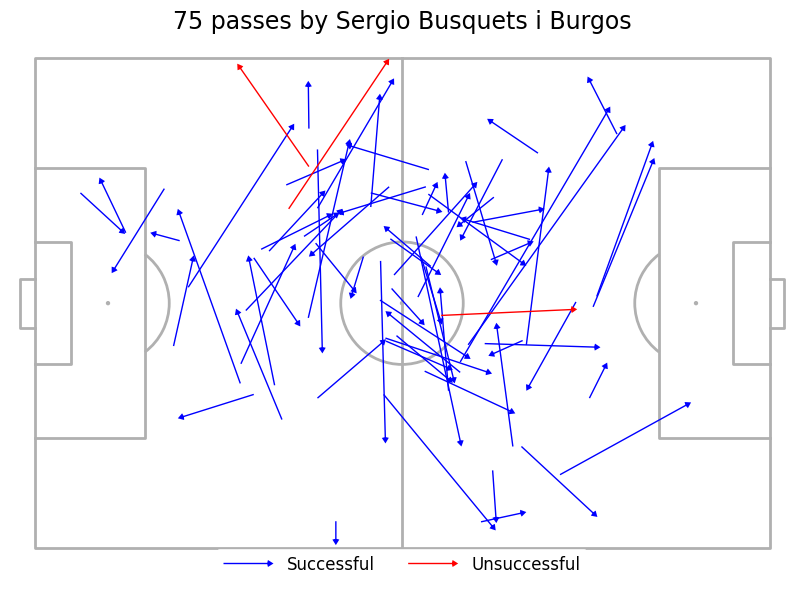

In [11]:
visualize_pass_network(events_df[events_df['type_name'] == 'Pass'], 'passes', 'Sergio Busquets i Burgos')

### Carry map

In [12]:
def visualize_carry_network(actions, actions_name, player_name, color='blue'):
    df_player_action = actions[actions["player_name"] == player_name]
    num_actions = len(df_player_action)

    fig, ax = pitch.draw(figsize=(12, 7), constrained_layout=True, tight_layout=False)

    pitch.arrows(df_player_action.x, df_player_action.y,
                 df_player_action.end_x, df_player_action.end_y,
                 width=1, headwidth=5, headlength=4, color=color, ax=ax, label=actions_name)

    ax.legend(handlelength=5, edgecolor='None', fontsize=15, loc='upper center', bbox_to_anchor=(0.5, 0.06), ncol=1)
    ax.set_title(f'{num_actions} {actions_name} by {player_name}', fontsize=17, pad=2)

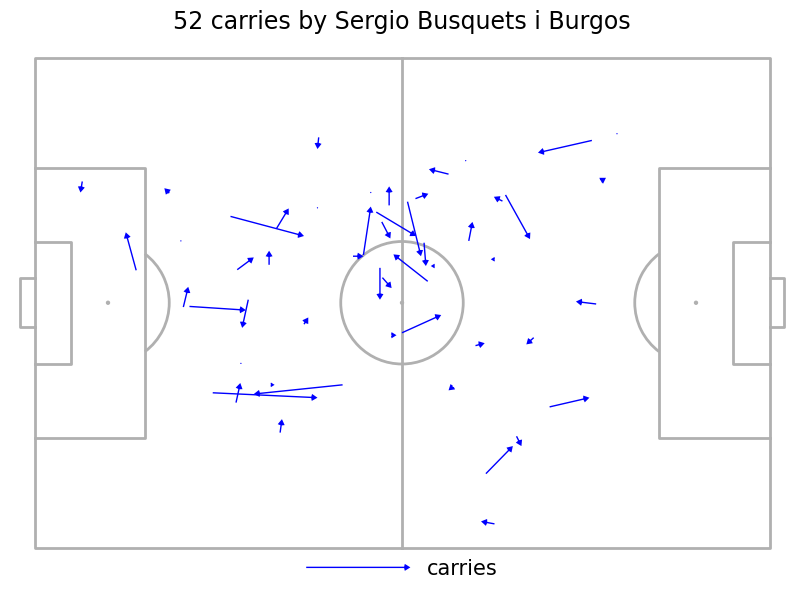

In [13]:
visualize_carry_network(events_df[events_df['type_name'] == 'Carry'], 'carries', 'Sergio Busquets i Burgos')

### Shot map

In [14]:
shots = events_df[events_df['type_name'] == 'Shot'][['team_name', 'player_name', 'x', 'y', 'under_pressure', 'outcome_name', 'technique_name', 'shot_statsbomb_xg', 'shot_one_on_one']]
shots.sort_values('shot_statsbomb_xg', ascending=False)

,team_name,player_name,x,y,under_pressure,outcome_name,technique_name,shot_statsbomb_xg,shot_one_on_one
605,Toronto FC,Deandre Kerr,108.0,32.5,NaN,Saved,Normal,0.298606,True
1159,Inter Miami,Lionel Andrés Messi Cuccittini,114.8,46.6,NaN,Off T,Volley,0.160210,NaN
214,Inter Miami,Josef Alexander Martínez Mencia,103.6,37.4,1.0,Off T,Normal,0.147720,NaN
3197,Inter Miami,Benjamin Cremaschi,111.5,52.3,NaN,Goal,Normal,0.136740,NaN
2228,Toronto FC,Lorenzo Insigne,106.8,40.2,NaN,Saved,Normal,0.128371,NaN
608,Toronto FC,Deandre Kerr,114.5,30.5,NaN,Post,Volley,0.109547,NaN
2097,Toronto FC,Lorenzo Insigne,99.9,38.5,NaN,Off T,Normal,0.083594,NaN
1865,Inter Miami,Facundo Farías,107.8,44.0,NaN,Goal,Volley,0.076869,NaN
2459,Inter Miami,Robert Taylor,101.1,51.0,NaN,Goal,Normal,0.076539,NaN
1061,Inter Miami,Lionel Andrés Messi Cuccittini,105.9,41.3,NaN,Blocked,Normal,0.073401,NaN


In [15]:
events_df[(events_df['type_name'] == 'Shot') & (events_df['player_name'] == 'Robert Taylor')][['team_name', 'player_name', 'x', 'y', 'under_pressure', 'outcome_name', 'technique_name', 'shot_statsbomb_xg', 'shot_one_on_one']]

,team_name,player_name,x,y,under_pressure,outcome_name,technique_name,shot_statsbomb_xg,shot_one_on_one
2459,Inter Miami,Robert Taylor,101.1,51.0,NaN,Goal,Normal,0.076539,NaN
2988,Inter Miami,Robert Taylor,104.9,53.0,NaN,Off T,Half Volley,0.041499,NaN
3942,Inter Miami,Robert Taylor,113.9,52.9,1.0,Goal,Half Volley,0.072968,True


In [16]:
events_df[(events_df['type_name'] == 'Shot') & (events_df['outcome_name'] == 'Goal')]

,id,index,period,timestamp,minute,second,possession,duration,match_id,type_id,type_name,possession_team_id,possession_team_name,play_pattern_id,play_pattern_name,team_id,team_name,tactics_formation,player_id,player_name,position_id,position_name,pass_recipient_id,pass_recipient_name,pass_length,pass_angle,pass_height_id,pass_height_name,end_x,end_y,body_part_id,body_part_name,sub_type_id,sub_type_name,x,y,under_pressure,outcome_id,outcome_name,counterpress,off_camera,technique_id,technique_name,aerial_won,shot_statsbomb_xg,end_z,shot_first_time,goalkeeper_position_id,goalkeeper_position_name,pass_cross,out,pass_switch,pass_assisted_shot_id,pass_shot_assist,shot_key_pass_id,pass_no_touch,substitution_replacement_id,substitution_replacement_name,dribble_nutmeg,shot_one_on_one,foul_committed_advantage,foul_won_advantage,foul_won_defensive,ball_recovery_recovery_failure,foul_committed_offensive,shot_deflected,block_deflection,dribble_overrun,injury_stoppage_in_chain,pass_goal_assist,pass_deflected
1865,83c67615-968b-4ef3-bfd1-ebd13da4d483,1866,1,00:47:25.332000,47,25,73,0.160000,3877115,16,Shot,1975,Inter Miami,4,From Throw In,1975,Inter Miami,None,32878.0,Facundo Farías,22.0,Right Center Forward,NaN,NaN,NaN,NaN,NaN,NaN,120.0,43.3,40.0,Right Foot,87.0,Open Play,107.8,44.0,NaN,97.0,Goal,NaN,NaN,95.0,Volley,NaN,0.076869,1.8,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN
2459,1a54731a-5f2b-4fd2-9ddf-a1d34e09a986,2460,2,00:08:01.665000,53,1,102,1.046102,3877115,16,Shot,1975,Inter Miami,1,Regular Play,1975,Inter Miami,None,29946.0,Robert Taylor,15.0,Left Center Midfield,NaN,NaN,NaN,NaN,NaN,NaN,120.0,36.6,40.0,Right Foot,87.0,Open Play,101.1,51.0,NaN,97.0,Goal,NaN,NaN,93.0,Normal,NaN,0.076539,0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0922bf10-29d4-4320-a17f-759f7e49d829,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3197,3e292edf-3362-420f-a9bf-b41b3f9f8361,3198,2,00:27:21.078000,72,21,128,0.828337,3877115,16,Shot,1975,Inter Miami,1,Regular Play,1975,Inter Miami,None,225209.0,Benjamin Cremaschi,15.0,Left Center Midfield,NaN,NaN,NaN,NaN,NaN,NaN,120.0,36.7,40.0,Right Foot,87.0,Open Play,111.5,52.3,NaN,97.0,Goal,NaN,NaN,93.0,Normal,NaN,0.136740,0.2,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7c8b629c-593d-4bca-bcda-40e4cb892fde,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3942,a11607c8-db30-4983-a3d6-a5e8def99531,3943,2,00:41:23.408000,86,23,146,0.618669,3877115,16,Shot,1975,Inter Miami,3,From Free Kick,1975,Inter Miami,None,29946.0,Robert Taylor,17.0,Right Wing,NaN,NaN,NaN,NaN,NaN,NaN,120.0,40.4,40.0,Right Foot,87.0,Open Play,113.9,52.9,1.0,97.0,Goal,NaN,NaN,91.0,Half Volley,NaN,0.072968,2.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ef60b35b-8a0b-4737-9793-62e9f3a19242,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
def plot_team_shots(pitch, ax, shots, team_name, marker_color, edge_color):
    team_shots = shots[shots.team_name == team_name].copy()
    
    # Mirror the x coordinates for the second team
    if team_name == shots.team_name.unique()[1]:
        team_shots['x'] = pitch.dim.right - team_shots['x']
        team_shots['end_x'] = pitch.dim.right - team_shots['end_x']

    # Non-goals
    pitch.scatter(team_shots[team_shots.outcome_name != 'Goal'].x, team_shots[team_shots.outcome_name != 'Goal'].y,
                  s=team_shots[team_shots.outcome_name != 'Goal'].shot_statsbomb_xg * 700,
                  edgecolors=edge_color, facecolors='none', linewidth=1, label='_nolegend_', ax=ax)
    # Goals
    pitch.scatter(team_shots[team_shots.outcome_name == 'Goal'].x, team_shots[team_shots.outcome_name == 'Goal'].y,
                  s=team_shots[team_shots.outcome_name == 'Goal'].shot_statsbomb_xg * 700,
                  c=marker_color, edgecolors=edge_color, linewidth=1, label='_nolegend_', ax=ax)

def visualize_teams_shot_map2(shots):
    fig, ax = pitch.draw(figsize=(12, 7), constrained_layout=True, tight_layout=False)
    team1, team2 = shots.team_name.unique()
    
    plot_team_shots(pitch, ax, shots, team1, 'blue', 'blue')
    plot_team_shots(pitch, ax, shots, team2, 'red', 'red')
    
    plt.scatter([], [], c='none', edgecolors='gray', linewidth=1, s=100, label='Shot')
    plt.scatter([], [], c='gray', edgecolors='gray', linewidth=1, s=100, label='Goal')

    plt.scatter([], [], s=100, edgecolors='gray', facecolors='none', linewidth=1, label='Low xG')
    plt.scatter([], [], s=500, edgecolors='gray', facecolors='none', linewidth=1, label='High xG')

    handles, labels = ax.get_legend_handles_labels()
    unique_handles, unique_labels = [], []
    for handle, label in zip(handles, labels):
        if label not in unique_labels:
            unique_handles.append(handle)
            unique_labels.append(label)
    
    ax.legend(unique_handles, unique_labels, handlelength=5, edgecolor='None', fontsize=12, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=4, handletextpad=-1.5)
    ax.set_title(f'Shot Map: {team1} vs {team2}', fontsize=17, pad=2)

    ax.text(0.85, 0.08, f'{team1} Shots', color='blue', fontsize=12, ha='center', va='center', transform=ax.transAxes)
    ax.text(0.15, 0.08, f'{team2} Shots', color='red', fontsize=12, ha='center', va='center', transform=ax.transAxes)

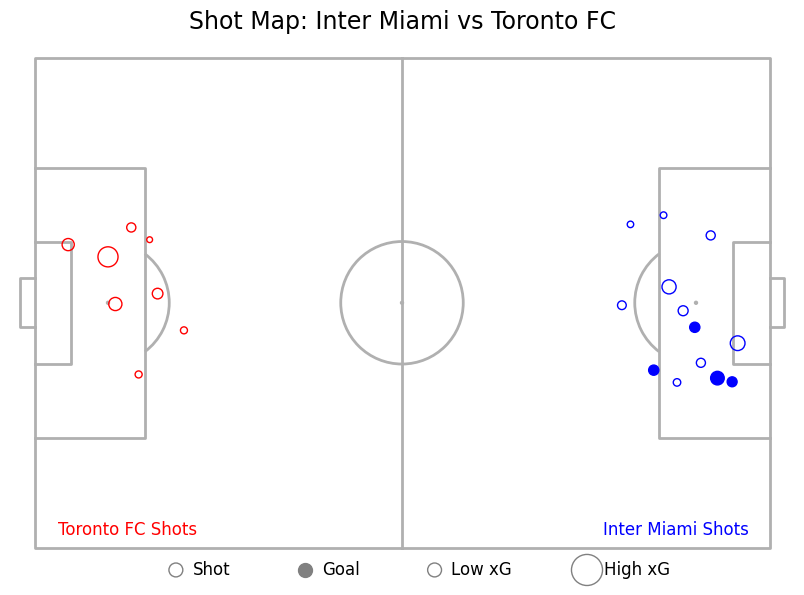

In [18]:
visualize_teams_shot_map2(events_df[events_df['type_name'] == 'Shot'])

### Heatmap

In [115]:
def plot_player_heatmap(events, player_name):
    player_events = events[events['player_name'] == player_name]
    
    touch_events = player_events[
        (player_events.type_name.isin(['Carry', 'Shot', 'Clearance', 'Foul Won'])) |
        ((player_events.type_name != 'Dribble') & (player_events.outcome_name == 'Complete')) |
        ((player_events.type_name == 'Pass') & (player_events.outcome_name.isnull()))|
        ((player_events.type_name == 'Ball Receipt') & (player_events.outcome_name.isnull()))
    ]
    
    pitch = Pitch(goal_type='box', line_zorder=2)
    fig, ax = pitch.draw(figsize=(12, 7))

    kde = sns.kdeplot(x=touch_events['x'], y=touch_events['y'], fill=True, cmap='rocket_r', bw_adjust=.5, ax=ax, levels=100, zorder=1, alpha=0.6)

    total_touches = len(touch_events)
    ax.text(60, -6, f'{player_name} Touches', fontsize=17, ha='center', color='black')
    ax.text(60, -2, f'Total Touches: {total_touches}', fontsize=13, ha='center', color='black', fontstyle='italic')

    sm = plt.cm.ScalarMappable(cmap='rocket_r')
    cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', pad=0.01, shrink=0.11, aspect=5)
    cbar.ax.tick_params(size=0, labelsize=0)
    cbar.set_ticks([])
    cbar.outline.set_visible(False)
    cbar.ax.text(-0.3, 0.5, 'Fewer\ntouches', ha='center', va='center', color='grey', transform=cbar.ax.transAxes, fontsize=10)
    cbar.ax.text(1.3, 0.5, 'More\ntouches', ha='center', va='center', color='grey', transform=cbar.ax.transAxes, fontsize=10)
    
    plt.setp(plt.getp(cbar.ax.axes, 'xticklabels'), color='black')

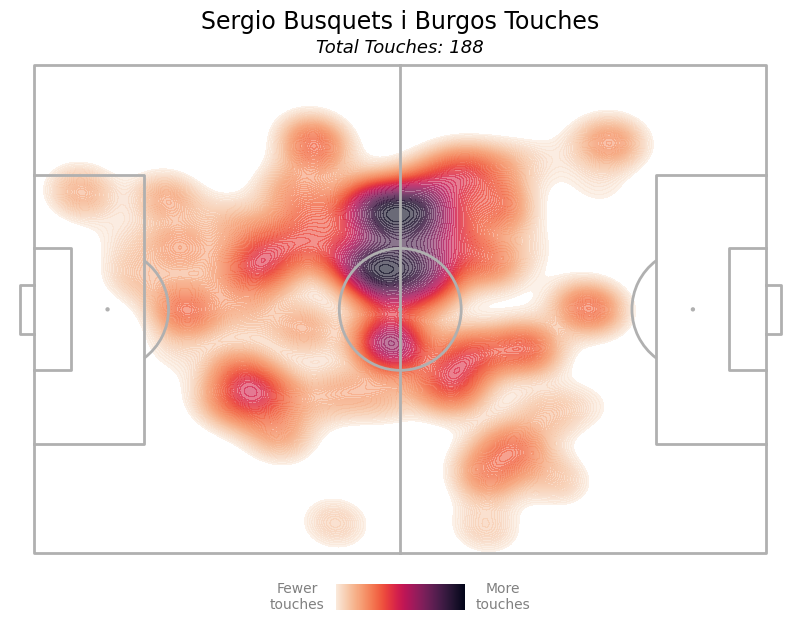

In [116]:
plot_player_heatmap(events_df, 'Sergio Busquets i Burgos')

### Formation

In [97]:
df_color = pd.read_csv('datasets/MLS_team_colors.csv')
mls_players = pd.read_csv('datasets/mls23_statsBomb_players.csv')
name_mapping = pd.Series(mls_players.short_name.values, index=mls_players.long_name).to_dict()

In [104]:
# Function to get team color
def team_color(team, color='MainColor'):
    return df_color[df_color['Team'] == team][color].iloc[0]

# Function to shorten player names
def shorten_name(name):
    closest_match = process.extractOne(name, name_mapping.keys(), score_cutoff=80)
    if closest_match:
        return name_mapping[closest_match[0]]
    print(f"No shortened name found for {name}")
    return name

# Function to plot team with text and scatter markers
def plot_team(event, tactics, team, flip=False, pitch=None, ax=None):
    starting_xi_event = event.loc[((event['type_name'] == 'Starting XI') & (event['team_name'] == team)), ['id', 'tactics_formation']]
    starting_xi = tactics.merge(starting_xi_event, on='id')
    formation = starting_xi['tactics_formation'].iloc[0]

    pitch.formation(formation, positions=starting_xi.position_id, kind='text',
                    text=starting_xi.player_name.apply(shorten_name), xoffset=+3,
                    flip=flip, half=True, va='center', ha='center', fontsize=9, color='black', ax=ax)
    
    mpl.rcParams['hatch.linewidth'] = 2
    mpl.rcParams['hatch.color'] = team_color(team, 'MainColor')
    pitch.formation(formation, positions=starting_xi.position_id, kind='scatter',
                    c=team_color(team, 'SecondaryColor'), hatch='||', linewidth=1.5, 
                    s=300, flip=flip, half=True, xoffset=0, ax=ax)

# Function to adapt Pitch coordinates to VerticalPitch
def create_custom_formation_df(pitch):
    custom_formation_df = pitch.formations_dataframe.copy()
    custom_formation_df['x_half'], custom_formation_df['y_half'] = custom_formation_df['y_half'], custom_formation_df['x_half']
    custom_formation_df['x_half_flip'], custom_formation_df['y_half_flip'] = custom_formation_df['y_half_flip'], custom_formation_df['x_half_flip']
    return custom_formation_df
    
# Function to plot team with player images
def plot_team_with_images(event, tactics, team, flip=False, formation_df=None, pitch=None, ax=None):
    starting_xi_event = event.loc[((event['type_name'] == 'Starting XI') & (event['team_name'] == team)), ['id', 'tactics_formation']]
    starting_xi = tactics.merge(starting_xi_event, on='id')
    formation = starting_xi['tactics_formation'].iloc[0]

    if isinstance(pitch, VerticalPitch):
        formation_df = create_custom_formation_df(pitch)
        formation_df = formation_df[formation_df['formation'] == formation]
        zoom = 0.11
        x_offset = -5
    else:
        formation_df = pitch.formations_dataframe[pitch.formations_dataframe['formation'] == formation]
        zoom = 0.14
        x_offset = 0
        y_offset = +5

    pitch.formation(formation, positions=starting_xi.position_id, kind='text',
                    text=starting_xi.player_name.apply(shorten_name), xoffset=x_offset,
                    yoffset=y_offset if 'y_offset' in locals() else None,
                    flip=flip, half=True, va='center', ha='center', fontsize=9, color='black', ax=ax)

    for _, row in starting_xi.iterrows():
        player_name = row['player_name']
        position_id = row['position_id']
        closest_match = process.extractOne(player_name, mls_players['long_name'], score_cutoff=80)
        if closest_match:
            image_path = mls_players[mls_players['long_name'] == closest_match[0]]['player_url'].values[0]
            img = plt.imread(image_path)
            
            coords_row = formation_df[formation_df['statsbomb'].apply(lambda x: position_id in x)]
            if not coords_row.empty:
                x, y = coords_row[['x_half', 'y_half']].values[0]
                if flip:
                    x, y = coords_row[['x_half_flip', 'y_half_flip']].values[0]
                imagebox = OffsetImage(img, zoom=zoom)
                if isinstance(pitch, VerticalPitch): y += 1
                ab = AnnotationBbox(imagebox, (x, y), frameon=False, box_alignment=(0.5, 0.5))
                ax.add_artist(ab)
            else:
                print(f"Position ID {position_id} not found in formation DataFrame")
        else:
            print(f"No match found for player: {player_name}")

# Plot the first formation graphic
def teams_colors_formation(events_df, tactics):
    teams = events_df.team_name.unique()
    pitch = VerticalPitch(line_alpha=0.5, goal_type='box', goal_alpha=0.5)
    fig, ax = pitch.draw(figsize=(7, 8))
    for i, team in enumerate(teams):
        plot_team(events_df, tactics, team, flip=bool(i), pitch=pitch, ax=ax)
    plt.title(f'{teams[0]} vs {teams[1]} Starting XI', fontsize=20, pad=20)
    plt.tight_layout()
    plt.show()

# Plot the second formation graphic
def players_image_formation(events_df, tactics):
    teams = events_df.team_name.unique()
    pitch = Pitch(line_alpha=0.5, goal_type='box', goal_alpha=0.5)
    fig, ax = pitch.draw(figsize=(11, 8))
    formation_df = pitch.formations_dataframe
    for i, team in enumerate(teams):
        plot_team_with_images(events_df, tactics, team, flip=bool(i), formation_df=formation_df, pitch=pitch, ax=ax)
    plt.title(f'{teams[0]} vs {teams[1]} Starting XI', fontsize=20)
    plt.tight_layout()
    plt.show()

# Plot the third formation graphic
def players_image_vertical_formation(events_df, tactics):
    teams = events_df.team_name.unique()
    pitch = VerticalPitch(line_alpha=0.5, goal_type='box', goal_alpha=0.5)
    fig, ax = pitch.draw(figsize=(11, 8))
    custom_formation_df = create_custom_formation_df(pitch)
    for i, team in enumerate(teams):
        plot_team_with_images(events_df, tactics, team, flip=bool(i), formation_df=custom_formation_df, pitch=pitch, ax=ax)
    plt.title(f'{teams[0]} vs {teams[1]} Starting XI', fontsize=20)
    plt.tight_layout()
    plt.show()

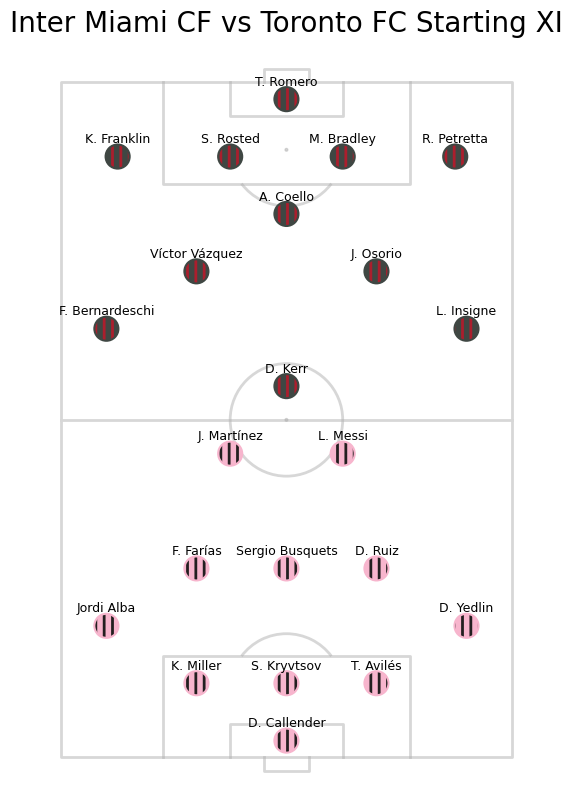

In [105]:
teams_colors_formation(events_df, tactics)

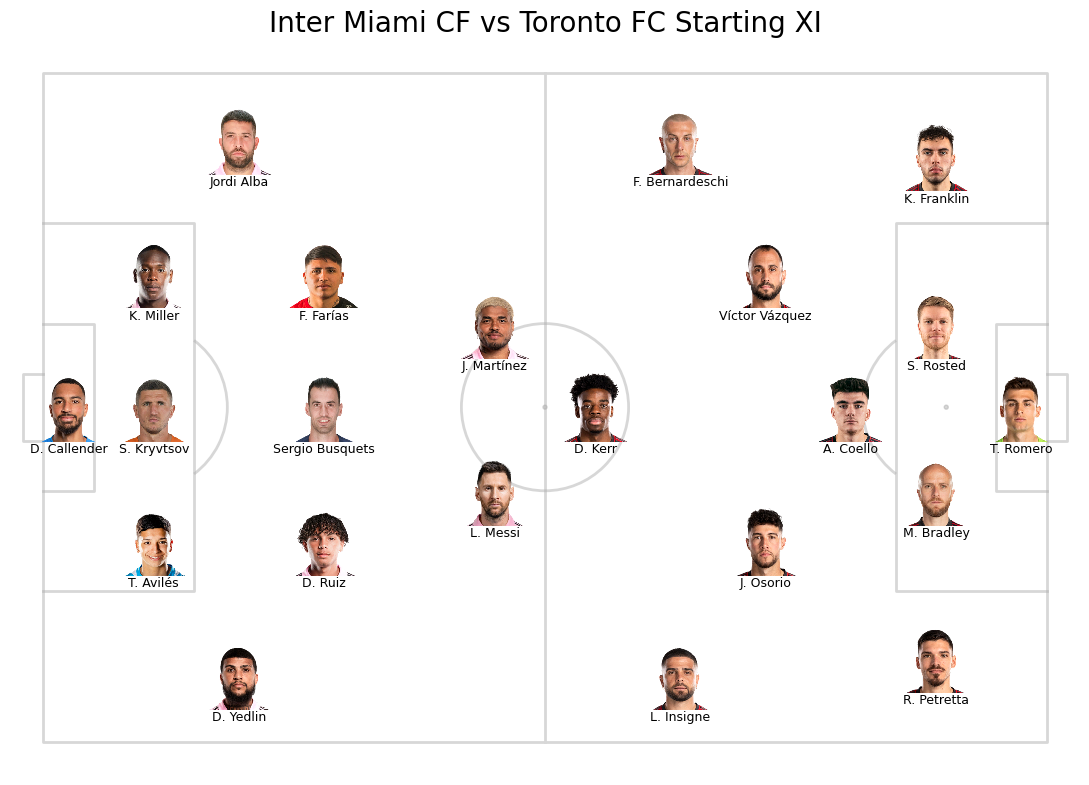

In [106]:
players_image_formation(events_df, tactics)

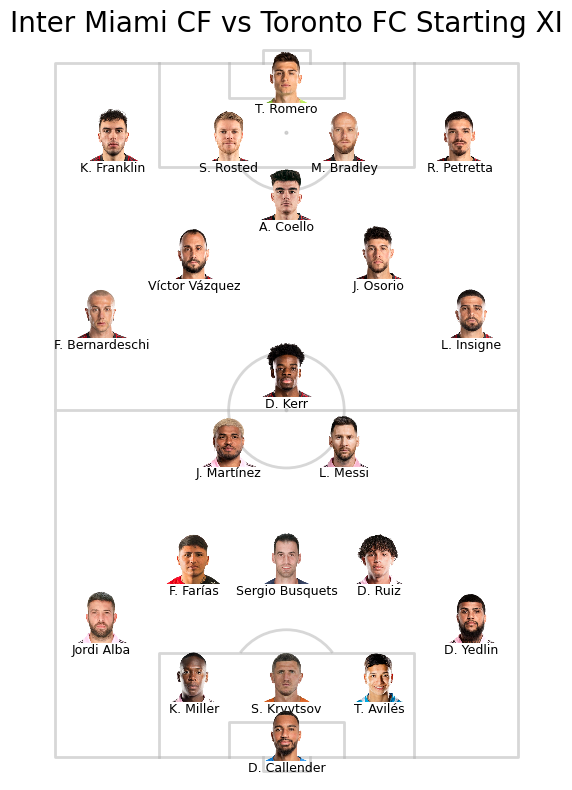

In [107]:
players_image_vertical_formation(events_df, tactics)